In [1]:
import SiemensQuadraProperties as sqp
from ActivityTools import *
from SimulationDataset import *

from multiprocessing import Pool
import numpy as np
import matplotlib.pyplot as mpl
myColours=[]
for colour in mpl.cm.viridis( np.linspace( 0.05, 0.8, 10 ) ):
    myColours.append( colour )
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=myColours)

params = {'legend.fontsize': 15,
          'legend.title_fontsize': 15,
          'legend.loc': "lower right",
          'axes.labelsize': 15,
          'xtick.labelsize': 15,
          'ytick.labelsize': 15}
mpl.rcParams.update(params)

The NEMU NU 2-2012 calculation for variation of NECR with source activity, although now we are only interested in the maximum value

In [2]:
def NECRatTimeF18( tracerData, crystalData, crystalActivity, detectorRadius, phantomLength, simulationWindow=1E-3, coincidenceWindow=4.7E-9 ):

    # NEMU NU 2-2012 says 650mm window for 700mm phantom, so keep the same relation
    zWindow = (phantomLength - 50) / 2
    
    # get volume in cc
    phantomRadius = 20.3 / 2.0
    phantomVolume = phantomRadius * phantomRadius * math.pi * phantomLength / 10.0 # assume length in mm
    
    necrAtTime = []
    trueAtTime = []
    rPlusSAtTime = []
    activityAtTime = []
    for time in range( 0, 700, 20 ):
        timeSec = float(time) * 60.0
        activity = F18ActivityAtTime( 1100E6, timeSec )

        necr, true, rPlusS = DetectedCoincidences( [activity, crystalActivity], [tracerData, crystalData], simulationWindow, coincidenceWindow, detectorRadius, ZMin=-zWindow, ZMax=zWindow )
        necrAtTime.append( necr )
        trueAtTime.append( true )
        rPlusSAtTime.append( rPlusS )
        activityAtTime.append( activity / phantomVolume )
    
    mpl.clf()
    return activityAtTime, necrAtTime, trueAtTime, rPlusSAtTime

WARNING: this calculation will take a long time

We chose a range of test detector lengths (the real lengths are calculated using discrete detector component sizes) and for each one find the peak NECR value with a given source. We then repeat for a range of different source lengths. This requires a large amount of simulation and calculation of the decay coincidences.

Both the simulation window size and the dataset size will have a significant impact on the total calculation time. Existing datasets will be re-used automatically (mitigating this issue somewhat) and the simulation window has the greatest effect on statistical fluctuation in the result (10ms window recommended, but this will be slow)

Although the simulation and the coincidence calculation are single-threaded, they can be run completely in parallel. A simple multiprocessing model gives close to ideal scaling.

In [3]:
# Investigate ideal detector length with Siemens geometry
def OneDetector( detectorLength, phantomLength, simulationWindow=1E-3, coincidenceWindow=4.7E-9 ):
    
    tracerData = CreateDataset( detectorLength, "Siemens", phantomLength, "LinearF18", 1000000, 435.0, 585.0 )
    crystalData = CreateDataset( detectorLength, "Siemens", phantomLength, "Siemens", 1000000, 435.0, 585.0 )
    crystalActivity = sqp.Lu176decaysInMass( sqp.DetectorMassLength( detectorLength ) )

    activityAtTimeSiemens, necrAtTimeSiemens, trueAtTimeSiemens, rPlusSAtTimeSiemens = NECRatTimeF18( tracerData, crystalData, crystalActivity, sqp.DetectorRadius(), phantomLength, simulationWindow, coincidenceWindow )

    return ( max( necrAtTimeSiemens ), sqp.DetectorDiscreteLength( detectorLength ) )

def PeakNECRWithLengthMultiprocess( phantomLength, simulationWindow=1E-3, coincidenceWindow=4.7E-9, processes=10 ):
    
    # Create the arguments for each process
    detectorLengths = [ 100, 300, 500, 700, 900, 1100, 1300, 1500, 1700, 1900 ]
    arguments = []
    for detectorLength in detectorLengths:
        arguments.append( ( detectorLength, phantomLength, simulationWindow, coincidenceWindow ) )
    
    # Launch a separate process for each detector length
    result = None
    with Pool( processes=processes ) as p:
        result = p.starmap( OneDetector, arguments )
    
    # Unpack the results
    realLengths = []
    maxNECR = []
    for entry in result:
        maxNECR.append( entry[0] )
        realLengths.append( entry[1] )
    return realLengths, maxNECR

detectorLengths = []
maxNECRlines = []
trialPhantoms = [ 300, 700, 1100, 1500 ]
for phantomLength in trialPhantoms:
    detectorLengths, maxNECR = PeakNECRWithLengthMultiprocess( phantomLength )
    maxNECRlines.append( maxNECR )

Re-using previous simulationRe-using previous simulationRe-using previous simulationRe-using previous simulationRe-using previous simulationRe-using previous simulationRe-using previous simulationRe-using previous simulationRe-using previous simulationRe-using previous simulation









80186.0 events loaded (1000000 simulated) with average 1.0345322126056917 hits/event
Re-using previous simulation
179419.0 events loaded (1000000 simulated) with average 1.0940089957027963 hits/event
106276.0 events loaded (1000000 simulated) with average 1.0058056381497233 hits/event
256715.0 events loaded (1000000 simulated) with average 1.1334047484564596 hits/event
Re-using previous simulation
Re-using previous simulation
316441.0 events loaded (1000000 simulated) with average 1.1551600456325193 hits/event
Re-using previous simulation
365151.0 events loaded (1000000 simulated) with average 1.167966129080846 hits/event
107054.0 events loaded (1000000 simulated) with average 1.0067629420666206 hits/

289733.0 events loaded (1000000 simulated) with average 1.106511857468773 hits/event
372537.0 events loaded (1000000 simulated) with average 1.148122199942556 hits/event
350858.0 events loaded (1000000 simulated) with average 1.1343791505395344 hits/event
Re-using previous simulation
Re-using previous simulation
Re-using previous simulation
387226.0 events loaded (1000000 simulated) with average 1.155730761880659 hits/event
106976.0 events loaded (1000000 simulated) with average 1.0071511367035597 hits/event
107046.0 events loaded (1000000 simulated) with average 1.0070343590605908 hits/event
Re-using previous simulation
107386.0 events loaded (1000000 simulated) with average 1.0076639412958859 hits/event
107376.0 events loaded (1000000 simulated) with average 1.0073480107286545 hits/event
107176.0 events loaded (1000000 simulated) with average 1.0074177054564455 hits/event
107221.0 events loaded (1000000 simulated) with average 1.0076477555702708 hits/event
107555.0 events loaded (100

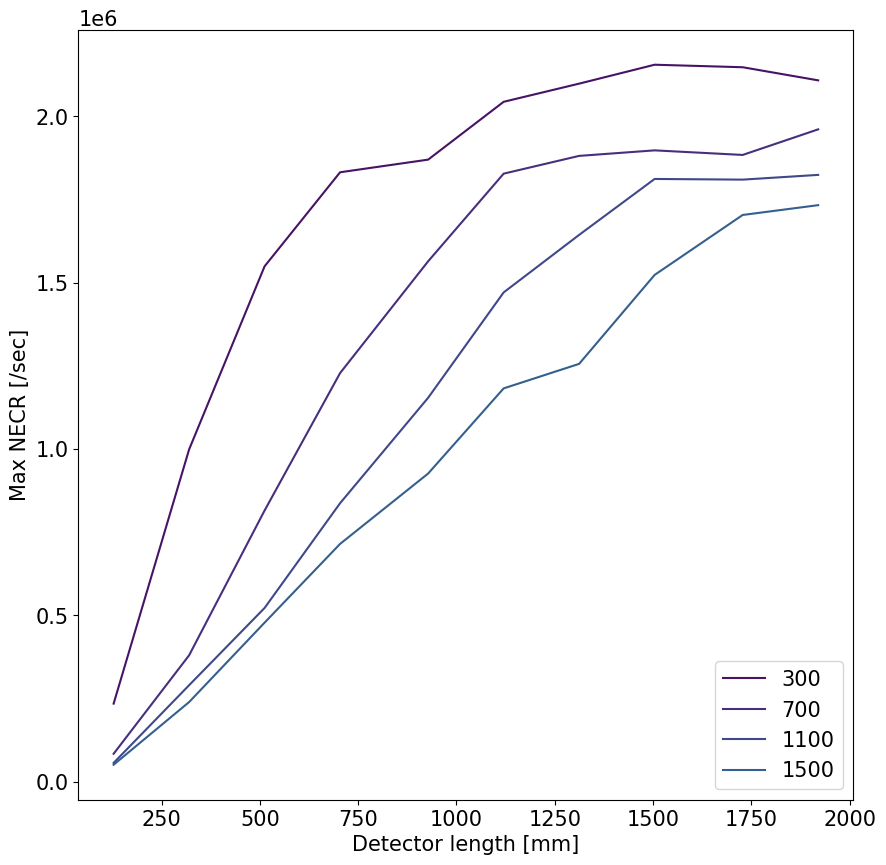

In [4]:
for i, phantomLength in enumerate( trialPhantoms ):
    mpl.plot( detectorLengths, maxNECRlines[i], label=phantomLength )

mpl.xlabel( "Detector length [mm]" )
mpl.ylabel( "Max NECR [/sec]" )
mpl.legend( trialPhantoms )
mpl.gcf().set_size_inches( 10, 10 )
mpl.show()